## Required Packages


In [1]:
#Required packages to run the code
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping
from keras.models import *
from keras.layers import *

## Generate the dataset

In [2]:
def get_adjacency(sz,p,undirected):
    '''
    Generates a realization of an Erdős–Rényi Graph Model, undirected or directed.
    -First generates of matrix of random floating point numbers in the range [0.0, 1.0].
    -If those values are <=p then there is no edge between pairs
    -Makes the matrix symmetric if the graoh is undirected

        Parameters:
                sz (int): Number of nodes
                p (int): Probability of existing an edge between each pair of nodes

        Returns:
                adj (2darray): Adjacency matrix
    '''
    adj = np.random.random((sz, sz)) <= p
    adj = np.triu(adj.astype(int))
    np.fill_diagonal(adj,0)
    if(undirected):
        adj = adj + adj.T
    return adj

def get_A(adj,c,rho):
    '''
    Generates the connectivity matrix (interaction weights) from the adjacency matrix according to the laplacian rule

        Parameters:
                adj (2darray): Adjacency matrix
                c,rho (int): Numbers between 0 and 1, to make the spectral radius < 1

        Returns:
                A (2darray): Connectivity matrix
    '''    
    sz = len(adj)
    Dvec = np.sum(adj, axis=1)
    Dmax = np.max(Dvec)
    ccc = c*1/Dmax
    D = np.diag(Dvec)
    L = D - adj
    Ap = np.eye(sz) - ccc*L
    A = rho * Ap
    return A

def tsg(A,tsize,x0,qsi):
    '''
    Generates the syntetic time series data given the connectivity matrix and the initial condiction x(0), 
    according to the dynnamical rule y(n + 1) = Ay(n) + x(n + 1)

        Parameters:
                A (2darray): Connectivity matrix
                tsize (int): Time series size - number of samples
                x0 (int): Initial condition x(0), in this case is zero
                qsi (int): Noise standart deviation 

        Returns:
                x (2darray): Time series data of the graph
    ''' 
    sz = len(A)
    x = np.zeros((tsize,sz))
    
    x[0,:] = np.ones((1,sz))*x0
    for i in range(1,tsize):
      for j in range(sz):
        x[i,j] = np.dot(A[j,:],x[i-1,:]) + qsi*np.random.randn(1)
    return x

def create_dataset(sz,p,c,rho,tsize,x0,qsi,undirected):
    '''
    Generates the synthectic data, extracts the features and returns the tranning/testing dataset

        Parameters:
                sz (int): Number of nodes
                p (int): Probability of existing an edge between each pair of nodes
                c,rho (int): Numbers between 0 and 1, to make the spectral radius < 1  
                tsize (int): Time series size - number of samples
                x0 (int): Initial condition x(0), in this case is zero
                qsi (int): Noise standart deviation 

        Returns:
                data (2darray): Matrix containing the feature-vectors between each pair of nodes
                target (1darray): Ground-truth - pairs are connected or disconnected
    '''     
    #Generate the adjacency and A matrices
    adj = get_adjacency(sz,p,undirected)
    A = get_A(adj,c,rho)
   
    #Is the graph undirected or directed
    if(undirected):
        
        #Create data structures
        upper = int(sz*(sz-1)/2)  #Number of elements in the upper matrix
        data = np.zeros((200,upper))
        target = np.zeros((1,upper))

        #Generates the synthetic time series
        x = tsg(A,tsize,x0,qsi)
        
        #Goes through each pair (of the upper matrix) and computes the time laged cross-correlation (excludes diagonal)
        counter = 0
        for j in range(sz):
            for k in range(j+1,sz):
                #Compute the cross correlation
                aux = signal.correlate(x[:,j],x[:,k], mode="full")
                #Extracts the first negative and positive lags
                data[:,counter] = aux[tsize-100:tsize+100]
                #Saves the data
                target[0,counter] = A[j,k]
                counter = counter + 1
    else:
        #Create data structures
        dsize = (sz*sz)-sz       #Number of elements excluding the diagonal
        data = np.zeros((200,dsize))
        target = np.zeros((1,dsize))

        #Generates the synthetic time series
        x = tsg(A,tsize,x0,qsi)
        
        #Goes through each pair and computes the time laged cross-correlation (excludes diagonal)
        counter = 0
        for j in range(sz):
            for k in range(sz):
                if(j!=k):
                    #Computes the cross correlation
                    aux = signal.correlate(x[:,j],x[:,k], mode="full")
                    #Extracts the firs negative and positive lags
                    data[:,counter] = aux[tsize-100:tsize+100]
                    #Saves the data
                    target[0,counter] = A[j,k]
                    counter = counter + 1 
    return data,target

In [3]:
#Parameters
sz = 50     #Number of nodes
p = 0.5      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75

#Define the range of noise variance
qsi = 0.1
tsize = 100000    #Number of samples (time series size)
x0 = 0            #Initial condition
   
#True if the graph is undirected, False if not
undirected = True
    
#Generate a dataset
#Data has a n x m shape, where n is the number of features and m the number of samples
data,target = create_dataset(sz,p,c,rho,tsize,x0,qsi,undirected)

In [4]:
#Scale data
data_scaled = data/np.max(data)

## Train and test a single model


In [5]:
def train_model(X_train,X_test,y_train,y_test):
    cb = EarlyStopping(monitor='val_loss', mode='min',patience=7)

    #CNN architecture
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, strides=2,activation='relu', input_shape=(200,1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    
    #Save the rmsesparse_categorical_crossentropy
    history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=1,callbacks=[cb])
    return model
 

#Transforms the ground-truth values into classes
y=target>0
y=y.astype(int)+1

#Split the data for trainning and testing
X_train, X_test, y_train, y_test = train_test_split(data_scaled.T,y.T, test_size=0.2, random_state=42)

#Reshapes the data into three dimensions
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#Train the model
model = train_model(X_train,X_test,y_train,y_test)

Epoch 1/1000
25/25 [==============================] - 2s 39ms/step - loss: 0.4752 - val_loss: 0.1279
Epoch 2/1000
25/25 [==============================] - 1s 32ms/step - loss: 0.0668 - val_loss: 0.0138
Epoch 3/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0282 - val_loss: 0.0111
Epoch 4/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0223 - val_loss: 0.0128
Epoch 5/1000
25/25 [==============================] - 1s 32ms/step - loss: 0.0201 - val_loss: 0.0091
Epoch 6/1000
25/25 [==============================] - 1s 33ms/step - loss: 0.0189 - val_loss: 0.0082
Epoch 7/1000
25/25 [==============================] - 1s 33ms/step - loss: 0.0164 - val_loss: 0.0076
Epoch 8/1000
25/25 [==============================] - 1s 32ms/step - loss: 0.0136 - val_loss: 0.0071
Epoch 9/1000
25/25 [==============================] - 1s 32ms/step - loss: 0.0178 - val_loss: 0.0065
Epoch 10/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0121 - val_lo

4/4 [==============================] - 0s 8ms/step
Accuracy:  100.0 %


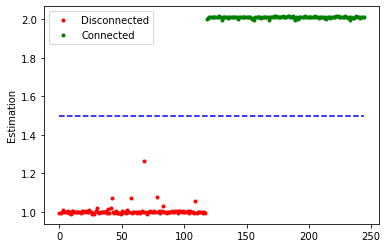

In [6]:
#Plot the testing results
#Disconnected samples
idd = y_test < 2
idd = np.squeeze(idd)

#Connected samples
idc = y_test > 1
idc = np.squeeze(idc)

#Threshold in the middle
threshold = np.ones((X_test.shape[0]))*1.5

#Predict the samples seperaly
dpred = model.predict(X_test[idd,:,:])
cpred =model.predict(X_test[idc,:,:])

fig=plt.figure()
plt.plot(np.arange(0,len(dpred)),dpred,'.r')
plt.plot(np.arange(len(dpred),len(dpred)+len(cpred)),cpred,'.g')
plt.plot(threshold,'--b')
plt.legend(["Disconnected","Connected"],loc='best')
plt.ylabel("Estimation")

trued = np.sum(dpred<1.5)
truec = np.sum(cpred>1.5)
true = trued + truec
accuracy_nn = true/(len(dpred)+len(cpred))*100
print("Accuracy:  " + str(accuracy_nn) + " %")

In [7]:
#Save or load a trainned CNN model
def save_model(model,name):
    model.save(name)

def load_model(name):
    return keras.models.load_model(name)

#Save = True to save the model
save=False
model_name='model'
if(save):
    save_model(model,model_name)

In [8]:
#Train and test a SVM with linear kernel
from sklearn import svm
import pickle
clf = svm.SVC(kernel="linear")
clf.fit(data_scaled[:,:].T, y.flatten())
pred = clf.predict(data_scaled.T)
true = y.flatten()
print("Accuracy:  " + str(sum(pred==true)/len(pred)*100) + " %")

#Save the model?
save=False
if(save):
    filename = 'svm_model.sav'
    pickle.dump(clf, open(filename, 'wb'))

Accuracy:  100.0 %


## Train multiple models select the best

In [9]:
def train_model(X_train,X_test,y_train,y_test):
    cb = EarlyStopping(monitor='val_loss', mode='min',patience=7)

    #CNN architecture
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, strides=2,activation='relu', input_shape=(200,1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    
    #Save the rmsesparse_categorical_crossentropy
    history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=1,callbacks=[cb])
    return model

In [10]:
nruns=5
models_list = []
performance_list = []

#Transforms the ground-truth values into classes
y=target>0
y=y.astype(int)+1


for i in range(nruns):
    #Split the data for trainning and testing
    X_train, X_test, y_train, y_test = train_test_split(data_scaled.T,y.T, test_size=0.2, random_state=42)

    #Reshapes the data into three dimensions
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    #Train the model
    model = train_model(X_train,X_test,y_train,y_test)
    
    #Save the data
    models_list.append(model)
    
    #Compute the performance according to a chosen metric on the testing set
    #I chose the identifiability in this case
    #Disconnected samples
    idd = y_test < 2
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 1
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:])
    cpred =model.predict(X_test[idc,:,:])
    
    id_gap = min(cpred)-max(dpred)
    
    #Add to performance list
    performance_list.append(id_gap)

Epoch 1/1000
25/25 [==============================] - 2s 37ms/step - loss: 0.4235 - val_loss: 0.0372
Epoch 2/1000
25/25 [==============================] - 1s 32ms/step - loss: 0.0481 - val_loss: 0.0112
Epoch 3/1000
25/25 [==============================] - 1s 32ms/step - loss: 0.0355 - val_loss: 0.0114
Epoch 4/1000
25/25 [==============================] - 1s 32ms/step - loss: 0.0289 - val_loss: 0.0081
Epoch 5/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0229 - val_loss: 0.0076
Epoch 6/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0212 - val_loss: 0.0064
Epoch 7/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0154 - val_loss: 0.0065
Epoch 8/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0146 - val_loss: 0.0083
Epoch 9/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0139 - val_loss: 0.0040
Epoch 10/1000
25/25 [==============================] - 1s 31ms/step - loss: 0.0130 - val_lo

Epoch 39/1000
25/25 [==============================] - 1s 31ms/step - loss: 1.6764e-04 - val_loss: 2.2279e-05
Epoch 40/1000
25/25 [==============================] - 1s 31ms/step - loss: 1.7747e-04 - val_loss: 1.9469e-05
Epoch 41/1000
25/25 [==============================] - 1s 32ms/step - loss: 1.4315e-04 - val_loss: 2.3606e-05
Epoch 42/1000
25/25 [==============================] - 1s 31ms/step - loss: 1.5866e-04 - val_loss: 2.0959e-05
Epoch 43/1000
25/25 [==============================] - 1s 32ms/step - loss: 1.0815e-04 - val_loss: 1.0940e-04
Epoch 44/1000
25/25 [==============================] - 1s 31ms/step - loss: 1.1664e-04 - val_loss: 2.3476e-05
Epoch 45/1000
25/25 [==============================] - 1s 33ms/step - loss: 2.1364e-04 - val_loss: 2.6162e-04
Epoch 46/1000
25/25 [==============================] - 1s 32ms/step - loss: 1.9213e-04 - val_loss: 6.1063e-05
Epoch 47/1000
4/4 [==============================] - 0s 10ms/step
Epoch 1/1000
25/25 [==============================] - 

In [11]:
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
print("Index:  " + str(idx))

Index:  2


In [12]:
#Save or load a trainned CNN
def save_model(model,name):
    model.save(name)

def load_model(name):
    return keras.models.load_model(name)

#Save = True to save the model
save=False
model_name='model'
if(save):
    save_model(best_model,model_name)